In [4]:
from Crypto.Util.number import inverse, sieve_base
def isqrt(n):
    x = n
    y = (x + 1) // 2
    while y < x:
        x = y
        y = (x + n // x) // 2
    return x



# Prerequisites

- DLP
- Chinese Remainder theorem
- Baby step Giant step

In [3]:
def solve_simple_eq(a, b, c, p):
    '''a + bx = c mod p'''
    c = c-a
    c = (c * inverse(b, p))% p
    return c%p

def crt(a_list, m_list):
    x = 0
    #starting values
    a = 0
    m = 1
    for i in range(len(m_list)):
        #general solution for the first equations x = a + m * y 
        #plug it in into the next equation and solve
        x = solve_simple_eq(a, m, a_list[i], m_list[i])
        
        a = a + m * x
        m = m * m_list[i]
        #print(a, m)        
    return a, m

def order_of_elem(g, p):
    N = 1
    temp = 1
    while True:
        temp = (temp * g) % p
        #print(temp)
        if(temp == 1):
            break
        N+=1
    return N


def bsgs(g, h, p):
    #calculate order of g

    N = order_of_elem(g, p)
    n = isqrt(N) + 1
    
    #create the collision lists
    lookup_table = {pow(g, j, p):j for j in range(n + 1)}
    
    c = inverse(pow(g, n, p), p)
    temp = h
    for i in range(n+1):
        temp = h*pow(c, i, p) % p
        if temp in lookup_table:
            return i*n + lookup_table[temp]
    return -1

# Theory

Explanation: https://www.youtube.com/watch?v=B0p0jbCGvWk&ab_channel=JimFowler

Observation: the discrete logarithm problem in a group $G$ is only as hard as the discrete logarithm problem in the largest subgroup of prime order in $G$ where $G$ = finite abelian group

*Intuition*: 
- G is not necesarily cyclic => an element $g$ is a generator of a cyclic subgroup $H$ with $|H| < |G|$ (number of elements). Therefore if we can work in H we will solve the problem easier
- Ex: if we work in  $\mathbb{Z}/ N\mathbb{Z}$, we know the number of elements is $\varphi(N)$. If our DLP exponend is in $\mathbb{Z} / N\mathbb{Z}$ we want to search for subgroups of $\mathbb{Z} / N\mathbb{Z}$

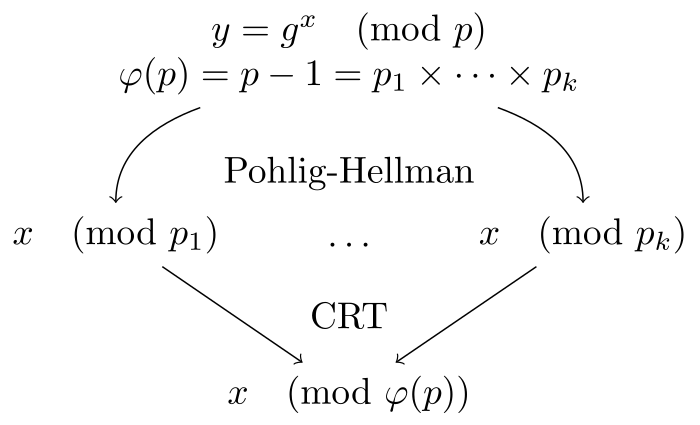

## Smooth numbers

https://en.wikipedia.org/wiki/Smooth_number
A **B-smooth** number is an integer whose prime factors are all less or equal to B

We know $\varphi(p) = p - 1 = q_1 \cdot ... \cdot q_k$. If $q_1 ... q_k$ are small enough we can find a way to efficiently solve the DLP


## DLP in groups of prime power order

Setup:
- Let G be a group of order (number of elements) $n = q^e$
- Let $g \in G$ be a generator
- let $h \in G$
We want to find $x$ s.t $g^x = h$



### Algorithm with code

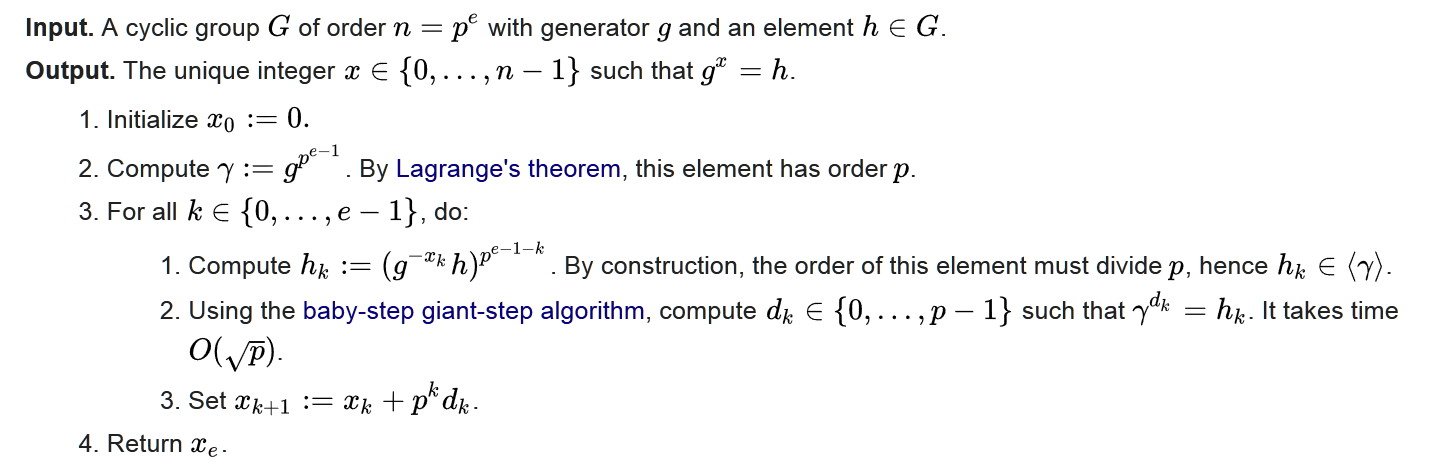

In [43]:
pow(2, -3, 5)

2

In [96]:
def ph_prime_power_order(g, h, p, q = None, e = None):
    
    if q is None and e is None:
        order_g = order_of_elem(g, p)
        
        #find prime q that divides the order
        for q in sieve_base:
            if order_g % q == 0:
                break
                
        #write order_g = q^e
        order_g_temp = order_g
        e = 0
        while order_g_temp % q == 0:
            e+=1
            order_g_temp //= q
        assert order_g_temp == 1, 'order didnt reach 1'
        assert order_g == pow(q, e), 'wrong p and q'
        print('order of G %s = %s^%s' % (order_g, q, e))
    
    x = 0
    gamma = pow(g, pow(p, e-1), p) #this element has order p and generates the subgroup where we will search
    for k in range(e):
        h_k = pow(pow(g, -x, p) * h,  pow(p, e-1-k), p)
        d_k = bsgs(gamma, h_k, p) #search for dlp in the subgroup
        x = x + pow(p, k) * d_k
        
    assert pow(g, x, p) == h, 'x not found'
    return x, q, e
    

In [97]:
g = 5448
h = 6909
p = 11251

In [98]:
x, q, e = ph_prime_power_order(g, h, p)

order of G 625 = 5^4


In [99]:
pow(g, x, p) == h

True

## DLP in general case

 Setup:
- Let G be a group of order (number of elements) $n = \Pi^r_{i=1} q_i^{e_i}$
- Let $g \in G$ be a generator
- let $h \in G$
We want to find $x$ s.t $g^x = h$

*Idea*:
- For each prime $q_i$ we search in the subgroup of order $q_i^{e_i}$ generated by some generator $g_i$ and save the result => we will have a system of modular equations
- Using CRT we will find the answer

### Algorithm with code
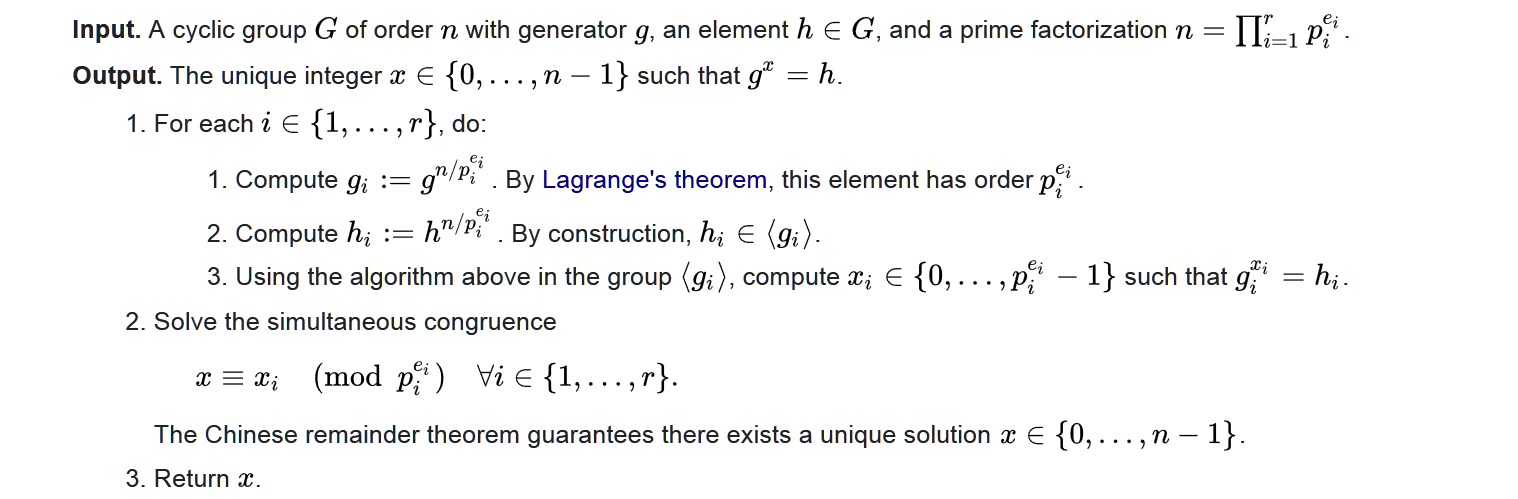

In [102]:
def pohlig_hellman(g, h, p):
    #find the prime factors
    q_list = []
    e_list = []
    a_list = []
    m_list = []
    order_g = order_of_elem(g, p)
    for q in sieve_base:
        if order_g % q != 0:
            continue
        else:
            order_g_temp = order_g
            e = 0
            while order_g_temp % q == 0:
                e+=1
                order_g_temp //= q
            q_list.append(q)
            e_list.append(e)
            x_i, _, _ = ph_prime_power_order(g, h, p, q, e)
            a_list.append(x_i)
            m_list.append(pow(q, e))
            
    x, m = crt(a_list, m_list)
    
    return x
    
            
            

In [103]:
g = 23
p = 11251
h = 9689
x = pohlig_hellman(g, h, p)

In [106]:
pow(g, x, p), pow(g, x, p) == h

(9689, True)

# Resources
- Explanation 2: https://www.youtube.com/watch?v=SmzUe_-e7oA&list=PLKXdxQAT3tCssgaWOy5vKXAR4WTPpRVYK&index=63&ab_channel=JeffSuzuki
- https://en.wikipedia.org/wiki/Pohlig%E2%80%93Hellman_algorithm
- I made another implementation at the end of this notebook https://nbviewer.jupyter.org/github/zademn/math_crypto_nb/blob/master/Chapter_2_Diffie_Hellman.ipynb